### Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
import sys
from pathlib import Path
path = Path.cwd()
input_dir = path.parent
import cv2
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [2]:
torch.cuda.is_available()

True

### Configuration

In [3]:
train_dir = input_dir/'train'
test_dir = input_dir/'test'
checkpoint_dir = input_dir/"experiment/checkpoint"
checkpoint_path = checkpoint_dir/"fasterrcnn_resnet50_fold4_best.pth"
cfg = {}

### Utils functions

In [4]:
def get_bboxes_areas(row_box):
    bbox = np.fromstring(row_box[1:-1], sep=",")
    x, y, w, h = bbox
    return x, y, x+w, y+h, w, h, w*h

def show_boxes(img_id, df):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    image_path = os.path.join(train_dir, img_id+'.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = df.loc[df.image_id==img_id, ["xmin", "ymin", "xmax", "ymax"]].values
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    ax.imshow(image)
    
def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def show_prediction(valid_df, image_id):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    boxes = valid_df.loc[image_id,"boxes"]
    if isinstance(boxes, str):
        boxes = np.fromstring(boxes[1:-1], sep=",")
        print(boxes)
    gts = df.loc[df.image_id==image_id, ["xmin", "ymin", "xmax", "ymax"]].values
    image = cv2.imread(os.path.join(train_dir, image_id+".jpg"), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    #image = cv2.resize(image, (512, 512))
    for i, box in enumerate(boxes):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    for box in gts:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
    ax.imshow(image)

class GlobalWheatDataset(Dataset):
    def __init__(self, df, image_ids, data_dir, transforms, train=True):
        self.df = df
        self.image_ids = image_ids
        self.data_dir = data_dir
        self.transforms = transforms
        self.train = train
    
    def __len__(self,):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        filename = image_id + ".jpg"
        image_path = os.path.join(self.data_dir, filename)
        image = self.load_image(image_path)
        if self.train:
            bboxes_areas = self.df[self.df.image_id==image_id][["xmin", "ymin", "xmax", "ymax", "area"]].values#.astype(np.float)
            #bboxes_areas = torch.as_tensor(bboxes_areas, dtype=torch.float32)  
            bboxes = bboxes_areas[:, :-1]
            area = torch.as_tensor(bboxes_areas[:, -1])
            labels = torch.ones(len(bboxes), dtype=torch.int64)
            image_id = torch.as_tensor([index], dtype=torch.int64)
            iscrowd = torch.zeros(len(bboxes_areas), dtype=torch.uint8)
            
            target = {"boxes": bboxes,
                      "labels": labels,
                      "image_id": image_id,
                      "area": area,
                      "iscrowd": iscrowd,
                      }
            sample = self.transforms(**{"image": image,
                                        "bboxes": bboxes,
                                        "labels": labels})
 
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32).reshape(-1, 4)
            target["boxes"] = bboxes
            image = sample["image"]
            return image, target, filename
        
        else:
            sample = self.transforms(**{"image": image})
            return sample["image"], image_id
        
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = Image.open(image_path).convert("RGB")
        return image

def get_train_transforms():
    return A.Compose(
        [
             A.RandomSizedCrop(min_max_height=(400, 400), height=800, width=800, p=0.5),

            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=800, width=800, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_test_transforms():
    return A.Compose(
        [
             A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
    )


def collate_fn(batch):
    sample = tuple(zip(*batch))
    return sample

train_transforms = get_train_transforms()
valid_transforms = get_valid_transforms()
test_transforms = get_test_transforms()

def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def get_train_valid_dataloaders(fold):
    train_idx, valid_idx = get_train_val_indexes(folds_df, fold)
    
    train_dataset = GlobalWheatDataset(df, train_idx, train_dir, train_transforms, train=True)
    valid_dataset = GlobalWheatDataset(df, valid_idx, train_dir, valid_transforms, train=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, drop_last=True, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

    return train_dataloader, valid_dataloader

def get_test_dataloader():
    test_dataset = GlobalWheatDataset(test_df, test_df.image_id.unique(), test_dir, test_transforms, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=10, num_workers=4)
    return test_dataloader


### Evaluation Metric

In [5]:
def iou_score(gt, pred) -> float:
    '''Computes the iou score between ground truth box and predicted box
    Args:
    gt: 1d array ground truth box [xmin, ymin, xmax, ymax]
    pred:1d array predicted box [xmin, ymin, xmax, ymax]
    Ouput:
    iou_score: float [0,1]'''
    #  if xmin_pred >= xmax_gt or xmax_pred <= xmin_gt return 0 (no intersection along x_axis)
    #  the same for y axis
    if (pred[0] >= gt[2] or pred[2] <= gt[0]) or (pred[1] >= gt[3] or pred[3] <= gt[1]):
        return 0
    
    max_x = min(pred[2], gt[2])
    min_x = max(pred[0], gt[0])
    max_y = min(pred[3], gt[3])
    min_y = max(pred[1], gt[1])
    intersection = (max_x - min_x) * (max_y - min_y)
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])
    gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    iou_score = intersection / (pred_area + gt_area - intersection)
    return iou_score

def find_best_match(pred, gts):
    '''Given a bounding box predictions, return the best matched groud truth
    bounding box.
    Args:
    pred: np.array (4,), predicted box
    gts: np.array(N, 4), ground truth bounding boxes
    Output:
    (gt box, score): tuple (matched box, score of match)'''
    index, max_match = max(enumerate(gts), key=lambda box: iou_score(box[1], pred))
    #print(iou_score(max_match, pred))
    return index, max_match, iou_score(max_match, pred)

def map_score(gts, preds, thresholds: list) -> float:
    ''' Compute map between predictions and ground truth'''
    ''' for threshold in thresholds:
            For box in predictions:
            find best matched score from ground truth (box, score)
            if score > threshold:
                tp ++
                update ground truch boxes (remove matched boxes)
            if score < threshold:
                fp ++
            for box in non-matched boxes:
                fn ++
            scores.add(tp/(tp+fp+fn))
        return the mean
    '''
    if len(gts) == 0:
        return 0, [0]

    thresholds = np.array(thresholds)
    positives = np.zeros((len(preds), len(thresholds)))
    matched_boxes = np.zeros((len(gts), len(thresholds)))
    
    for i, box in enumerate(preds):
        
        index, best_box, score = find_best_match(box, gts)
        mask = score >= thresholds
        matched_boxes[index, mask] += 1
        positives[i, mask] += 1
    
    tp = np.sum(matched_boxes>=1, axis=0)
    fp_matched = np.sum(matched_boxes, axis=0) - tp
    #print(fp_matched)
    fp_detected = len(preds) - np.sum(positives, axis=0)
    #print(fp_detected)
    fp = fp_matched + fp_detected
    fn = len(gts) - tp
    scores = tp/(tp + fp + fn)
    score = np.mean(scores)
    # print(fp)
    # print(positives)
    # print(matched_boxes)
    return score, scores

### Load Dataframes

In [6]:
df = pd.read_csv(input_dir/'train.csv')
test_df = pd.read_csv(input_dir/"sample_submission.csv")
valid_df = pd.read_csv("validation.csv")

In [7]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1
df['w'] = -1
df['h'] = -1
df['area'] = 0
df[['xmin', 'ymin', 'xmax', 'ymax', 'w', 'h', 'area']] = np.stack(df['bbox'].apply(lambda row_box: get_bboxes_areas(row_box)))
df.drop(columns=["bbox"], inplace=True)
df.head(1)

,image_id,width,height,source,xmin,ymin,xmax,ymax,w,h,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0,56.0,36.0,2016.0


In [8]:
df = df.drop([113947, 121633, 2159, 3687, 117344, 118211, 173, 147504], axis=0)
df = df.drop(df.loc[(df.w<20)|(df.h<20)].index.values, axis=0)
df = df.drop(df.loc[df.image_id=="a1321ca95"].index.values)

In [9]:
%time
folds_df = df.groupby(["image_id", "source"])["source"].count().to_frame(name="bbox_count").reset_index()
folds_df['stratify_group'] = np.char.add(folds_df["source"].values.astype(str), folds_df['bbox_count'].apply(lambda x: f'_{x // 20}').values.astype(str))
folds_df['mean_area'] = df.groupby(["image_id"])["area"].mean().values
folds_df['std_area'] = df.groupby(["image_id"])["area"].std().values
folds_df['fold'] = 0
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
for fold, (train_index, test_index) in enumerate(skf.split(folds_df, folds_df.stratify_group)):
    folds_df.loc[test_index, 'fold'] = fold
folds_df.head(10)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16.9 µs


/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold
0,00333207f,arvalis_1,55,arvalis_1_2,6375.381818,4341.766616,1
1,005b0d8bb,usask_1,20,usask_1_1,16111.050000,7719.394580,4
2,006a994f7,inrae_1,25,inrae_1_1,13007.560000,4950.205695,2
3,00764ad5d,inrae_1,41,inrae_1_2,8070.024390,4119.973019,3
4,00b5fefed,arvalis_3,25,arvalis_3_1,12841.760000,4806.171096,0
5,00b70a919,arvalis_3,7,arvalis_3_0,7134.571429,1645.453520,3
6,00e903abe,arvalis_1,40,arvalis_1_2,9208.250000,5087.405226,2
7,00ea5e5ee,arvalis_1,55,arvalis_1_2,3196.145455,1734.487078,2
8,010b216d4,usask_1,36,usask_1_1,13536.305556,8245.541718,0
9,010c93b99,inrae_1,16,inrae_1_0,14309.437500,6644.134365,0


### Model

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator


def load_model():
    # load a model pre-trained pre-trained on COCO
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator = AnchorGenerator(
        anchor_sizes, aspect_ratios
    )
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained_backbone=True,
                                                                          rpn_pre_nms_top_n_train=2000,
                                                                          rpn_post_nms_top_n_train=2000,
                                                                          rpn_fg_iou_thresh=0.4,
                                                                          rpn_anchor_generator=rpn_anchor_generator,
                                                                          box_detections_per_img=120,
                                                                          )

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def load_checkpoint(model, checkpoint_path=checkpoint_dir/'fasterrcnn_resnet50_fpn_epoch_13_.pth', device="cpu"):
    #checkpoint_path = path.parent/"input/checkpoint2/global_wheat_fasterrcnn_epoch_5.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)["model_state_dict"]
    for key in list(checkpoint.keys()):
            if 'model.' in key:
                checkpoint[key.replace('model.', '')] = checkpoint[key]
                del checkpoint[key]
    model.load_state_dict(checkpoint)
    return model

### Evaluation Function

In [11]:
def predict(model, val_dataloader, device="cpu", threshold=0.6):
    model.to(device)
    model.eval()
    images = []
    all_predictions = []
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            print(f"Validation iteration: [{i+1}/{len(val_dataloader)}]\r", end="")
            images, targets, file_names = batch
            images = [img.to(device) for img in images]
            predictions = model(images)
            image_ids = [fname.split(".")[0] for fname in file_names]
            all_predictions.append((predictions, targets, image_ids))
            del batch
    return all_predictions
                        
def score(all_predictions, threshold=0.6):
    image_ids = []
    total_score = []
    map_scores = []

    boxes = []
    for (predictions, targets, images_id) in all_predictions:
        
        for i, pred in enumerate(predictions):
            probas = pred["scores"].cpu().numpy()
            mask = probas > threshold
            preds = pred["boxes"].detach().cpu().numpy()
            gts = targets[i]["boxes"].cpu().numpy()
            preds = preds[mask]
            score, scores = map_score(gts, preds, thresholds=[.5, .55, .6, .65, .7, .75])
            map_scores.extend(scores)
            total_score.append(score)
            boxes.append(preds)
        image_ids.extend(images_id)

    return np.mean(map_scores), map_scores, image_ids, boxes, total_score
        
def evaluate_(model, val_dataloader, device="cpu", threshold=0.6):
    model.to(device)
    model.eval()
    image_ids = []
    total_score = []
    boxes = []
    map_scores = []
    with torch.no_grad():

        for i, batch in enumerate(val_dataloader):
            print(f"Validation iteration: [{i+1}/{len(val_dataloader)}]\r", end="")
            images, targets, file_names = batch
            images = [img.to(device) for img in images]
            predictions = model(images)
            for i, pred in enumerate(predictions):
                probas = pred["scores"].cpu().numpy()
                mask = probas > threshold
                preds = pred["boxes"].detach().cpu().numpy()
                gts = targets[i]["boxes"].cpu().numpy()
                preds = preds[mask]
                score, scores = map_score(gts, preds, thresholds=[.5, .55, .6, .65, .7, .75])
                map_scores.extend(scores)
                total_score.append(score)
                boxes.append(preds)
            image_ids.extend([fname.split(".")[0] for fname in file_names])
        print()
    return np.mean(map_scores), map_scores, image_ids, boxes, total_score

In [12]:
tdl, val_dataloader = get_train_valid_dataloaders(4)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model = load_model()
load_checkpoint(model, checkpoint_path, device=device)
predictions = predict(model, val_dataloader, device=device)



/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [40]:
#mAP_score, map_scores, image_ids, boxes, total_score = evaluate_(model, val_dataloader, device=device)
mAP_score, map_scores, image_ids, boxes, total_score = score(predictions, threshold=0.68)

In [41]:
print(mAP_score)

0.6680698344138419


In [28]:
valid_df = folds_df.set_index(folds_df.image_id).loc[image_ids]

In [29]:
valid_df["map_score"] = total_score
valid_df["boxes"]  = boxes
valid_df["pred_bbox_count"] = valid_df.apply(lambda row: len(row["boxes"]), axis=1)

In [30]:
valid_df.sort_values(by=["map_score"], ascending=True).head(20)

,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold,map_score,boxes,pred_bbox_count
image_id,,,,,,,,,,
d79169f0e,d79169f0e,arvalis_1,46,arvalis_1_2,10255.956522,5410.851529,4,0.191458,"[[2.1806006, 255.07939, 112.814, 436.1707], [2...",44
409a8490c,409a8490c,arvalis_3,14,arvalis_3_0,5931.642857,3963.839739,4,0.209608,"[[476.60797, 264.07553, 603.3327, 356.6204], [...",11
0f0bb7843,0f0bb7843,arvalis_2,22,arvalis_2_1,9744.681818,3508.486248,4,0.215290,"[[369.39856, 910.8715, 459.88293, 992.02435], ...",15
b58605092,b58605092,arvalis_2,18,arvalis_2_0,10108.277778,3052.269990,4,0.216847,"[[574.0025, 871.73706, 662.4869, 973.85144], [...",11
efc4f0374,efc4f0374,arvalis_2,21,arvalis_2_1,7495.047619,4254.367244,4,0.225434,"[[254.50009, 227.81161, 353.44305, 344.65805],...",19
e69cbaece,e69cbaece,arvalis_3,9,arvalis_3_0,5936.888889,3404.311107,4,0.268254,"[[909.3751, 110.762314, 1023.4467, 200.9636], ...",8
80ea429bf,80ea429bf,arvalis_1,41,arvalis_1_2,3096.219512,1546.581739,4,0.292692,"[[831.3736, 476.41623, 921.89685, 560.362], [3...",28
f65604566,f65604566,arvalis_1,38,arvalis_1_1,9896.842105,6061.825252,4,0.336848,"[[783.52014, 362.92654, 879.6204, 582.9778], [...",30
348f3c34b,348f3c34b,arvalis_1,49,arvalis_1_2,2983.142857,1465.386468,4,0.343095,"[[299.0901, 572.0269, 368.3373, 656.9002], [55...",42


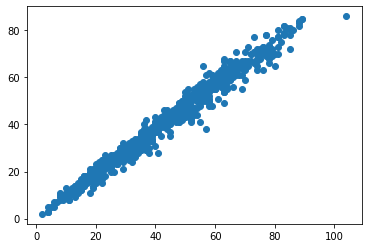

In [31]:
plt.scatter(valid_df.bbox_count, valid_df.pred_bbox_count)

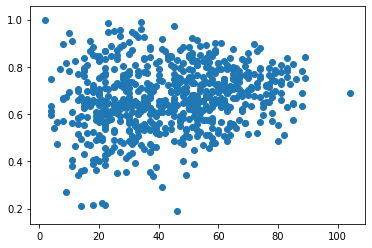

In [32]:
plt.scatter(valid_df.bbox_count, valid_df.map_score)

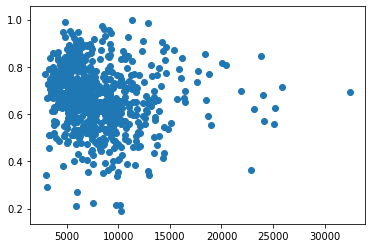

In [33]:
plt.scatter(valid_df.mean_area, valid_df.map_score)

In [34]:
valid_df.loc[valid_df.map_score==valid_df.map_score.min()]

,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold,map_score,boxes,pred_bbox_count
image_id,,,,,,,,,,
d79169f0e,d79169f0e,arvalis_1,46,arvalis_1_2,10255.956522,5410.851529,4,0.191458,"[[2.1806006, 255.07939, 112.814, 436.1707], [2...",44


In [35]:
valid_df.groupby(["source"])["map_score"].describe()

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
arvalis_1,210.0,0.591022,0.103382,0.191458,0.531644,0.606917,0.657074,0.806988
arvalis_2,41.0,0.505294,0.137181,0.215290,0.411574,0.494626,0.588078,0.825123
arvalis_3,113.0,0.652876,0.121951,0.209608,0.590495,0.647900,0.719281,1.000000
ethz_1,150.0,0.723659,0.083147,0.455696,0.676049,0.727511,0.787842,0.898042
inrae_1,34.0,0.750320,0.123037,0.363092,0.673857,0.768135,0.835356,0.986111
rres_1,87.0,0.820159,0.091437,0.510250,0.752860,0.836708,0.876524,0.990476
usask_1,39.0,0.673303,0.103171,0.440764,0.611729,0.656933,0.745053,0.865338


In [36]:
valid_df.loc[valid_df.source=="arvalis_2"].sort_values("map_score", ascending=True).head()

,image_id,source,bbox_count,stratify_group,mean_area,std_area,fold,map_score,boxes,pred_bbox_count
image_id,,,,,,,,,,
0f0bb7843,0f0bb7843,arvalis_2,22,arvalis_2_1,9744.681818,3508.486248,4,0.215290,"[[369.39856, 910.8715, 459.88293, 992.02435], ...",15
b58605092,b58605092,arvalis_2,18,arvalis_2_0,10108.277778,3052.269990,4,0.216847,"[[574.0025, 871.73706, 662.4869, 973.85144], [...",11
efc4f0374,efc4f0374,arvalis_2,21,arvalis_2_1,7495.047619,4254.367244,4,0.225434,"[[254.50009, 227.81161, 353.44305, 344.65805],...",19
a76360ece,a76360ece,arvalis_2,13,arvalis_2_0,12953.076923,6252.090363,4,0.344048,"[[392.32178, 957.7938, 479.976, 1022.5905], [5...",14
5a77d4b5d,5a77d4b5d,arvalis_2,14,arvalis_2_0,12892.500000,4565.857553,4,0.360722,"[[311.07904, 343.00446, 426.0888, 441.78802], ...",14


(1024, 1024, 3)


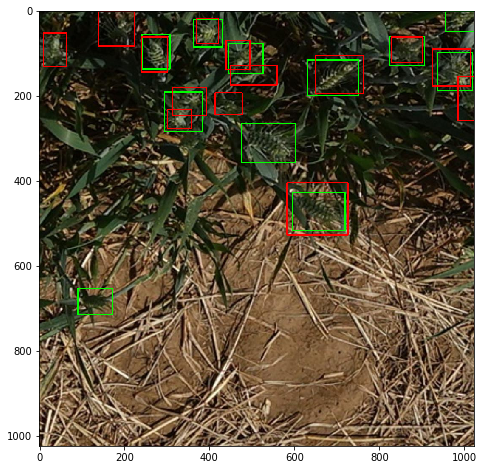

In [43]:
show_prediction(valid_df.set_index(["image_id"]), "409a8490c")

In [32]:
df.sort_values(["area"], ascending=False).head()

,image_id,width,height,source,xmin,ymin,xmax,ymax,w,h,area
52868,9a30dd802,1024,1024,inrae_1,3.0,301.0,420.0,671.0,417.0,370.0,154290.0
54702,ad6e9eea2,1024,1024,inrae_1,709.0,422.0,1018.0,913.0,309.0,491.0,151719.0
54892,9adbfe503,1024,1024,inrae_1,363.0,286.0,750.0,660.0,387.0,374.0,144738.0
1259,69fc3d3ff,1024,1024,usask_1,0.0,609.0,346.0,1024.0,346.0,415.0,143590.0
53930,51f2e0a05,1024,1024,inrae_1,5.0,535.0,453.0,826.0,448.0,291.0,130368.0


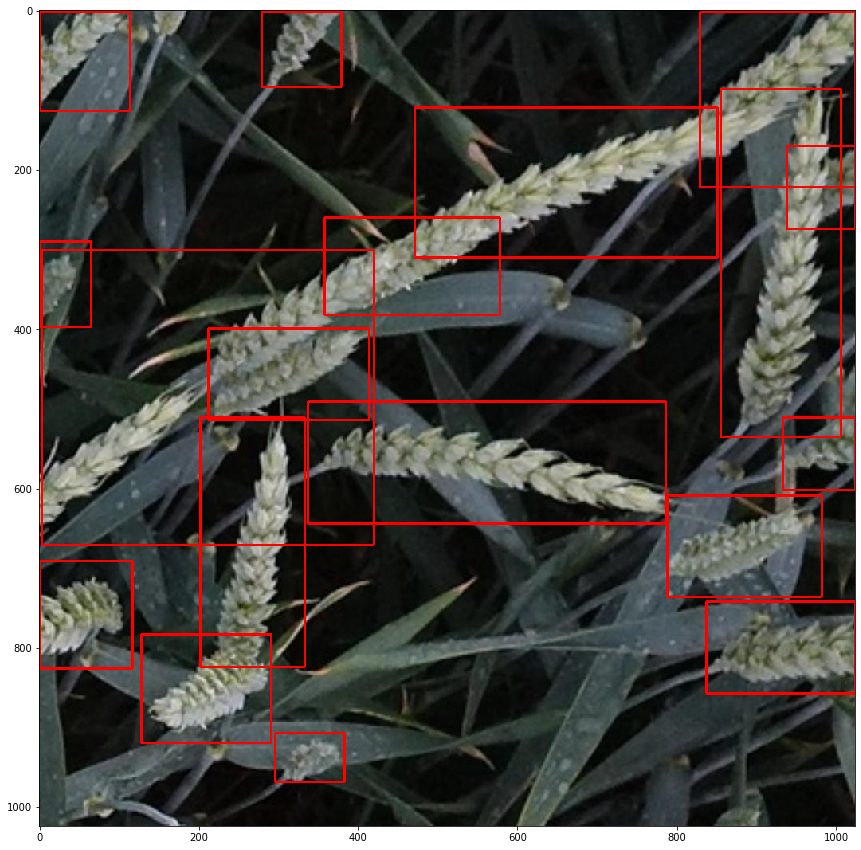

In [35]:
show_boxes("9a30dd802", df)

In [43]:
def two_stage_evaluate(model, val_dataloader, device="cpu", threshold=0.8):
    model.to(device)
    model.eval()
    image_ids = []
    total_score = []
    map_scores = []
    total_boxes = []
    list_images = []
    with torch.no_grad():
        
        for i, batch in enumerate(val_dataloader):
            print(f"Validation iteration: [{i+1}/{len(val_dataloader)}]\r", end="")
            images, targets, file_names = batch
            images = [img.to(device) for img in images]
            predictions = model(images)
            boxes = []
            for i, pred in enumerate(predictions):
                probas = pred["scores"].cpu().numpy()
                mask = probas > threshold
                preds = pred["boxes"].detach().cpu().numpy()
                preds = preds[mask]
                boxes.append(preds)
            total_boxes.append(boxes)
            list_images.append([image.permute(1, 2, 0).detach().cpu().numpy() for image in images])
    return list_images, total_boxes

In [44]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model = load_model()
load_checkpoint(model, checkpoint_path, device=device)
images, boxes = two_stage_evaluate(model, val_dataloader, device="cuda")

/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/adnen/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/adnen/anaconda3/envs/fastai/lib/pyt

KeyboardInterrupt: 

In [82]:
batch = batches[0]

In [83]:
ims, bx = batch
image = ims[0].copy()
for b in bx[0]:
    image[:, int(b[1]): int(b[3]), int(b[0]): int(b[2])] = 0
image = image.transpose(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


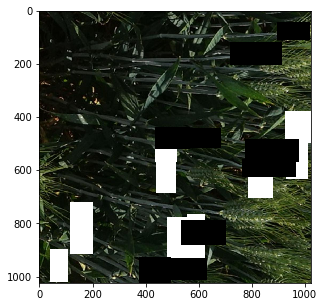

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image)

In [68]:
a = np.array([[1, 2, 3], [4, 5, 6]])

In [10]:
get_train_val_indexes(folds_df, 0)  # '00b5fefed', '010b216d4', '010c93b99', '013fd7d80', '0172359d2

(array(['00333207f', '005b0d8bb', '006a994f7', ..., 'ffbfe7cc0',
        'ffc870198', 'ffdf83e42'], dtype=object),
 array(['00b5fefed', '010b216d4', '010c93b99', '013fd7d80', '0172359d2',
        '025ea7326', '029c79463', '02e02e347', '030314634', '035bdc07a',
        '03dd40d7b', '04201d2d6', '04f906b5d', '059125072', '060fd0cd8',
        '06152e5bf', '069719eab', '077ba8cca', '077c0bddb', '086349fe8',
        '08dd31605', '0bb1adbd8', '0c3d9007c', '0ca276259', '0cca0ffc8',
        '0d4128a74', '0dc2de69d', '0dc9eb168', '0df7f89c3', '0f4911203',
        '1104e6a0d', '12b724773', '132a92818', '147830115', '14da8934d',
        '152d16ce7', '15c025a28', '1690036d7', '16a0dc111', '16d922704',
        '1794c0a24', '19c242397', '1a106f404', '1b399c9a7', '1b547b682',
        '1c6e42234', '1d74edc1e', '1e9ff110c', '1f387ec08', '20697ca8f',
        '20a86a215', '20ebdfc4b', '211487419', '21504c374', '21a9818dd',
        '2204976da', '229716799', '229d8a499', '22c8f2030', '22f341965',
        '